## Imports and Helpers

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython import display
%matplotlib inline

In [178]:
def video_tag(path,width=300,height=240,title=""):
    '''
    generates an HTML fragmentfor displaying the video in path in the notebook
    '''
    return """
    <div style="float:left;padding-left:5px">
    <p>{3}</p>
    <video width="{1}" height="{2}" controls>
      <source src="{0}">
    </video>
    </div>
    """.format(path,width,height,title)

In [179]:
def table_tag(fragments, columns):
    column = 1
    s = '<table><tr>'
    for fragment in fragments:
        s = s + '<td>' + fragment + '</td>'
        column = column + 1
        if column > columns:
            s = s + '</tr><tr>'
            column = 1
    s = s + '</td></tr></table>'
    return s

In [180]:
def big_figure():
    fig = plt.figure()
    fig.set_size_inches(w=15,h=10)
    return fig

## Settings

In [181]:
run_folder = 'tracks/desk/routes/X/runs/1'
front_meters_per_odometer_tick = 0.002528
rear_meters_per_odometer_tick = 0.002017
front_wheelbase_width_in_meters = 0.2413
rear_wheelbase_width_in_meters = 0.2667
wheelbase_length_in_meters = 0.33655

## Analysis

In [182]:
route_folder = os.path.dirname(os.path.dirname(run_folder)) # two folders up
route_folder

'tracks/desk/routes/X'

In [183]:
# Create / Show videos

import subprocess
video_tags = []
for f in ['video_left','video_right']:
    mp4_path = os.path.join(run_folder,f+'.mp4')
    if not os.path.exists(mp4_path):
        avi_path = os.path.join(run_folder,f+'.avi')
        if os.path.exists(avi_path):
            s = 'ffmpeg -i "{0}" -vcodec h264 -acodec copy "{1}"'.format(avi_path,mp4_path)
            subprocess.check_call(s,shell=True)
    if os.path.exists(mp4_path):
        video_tags.append(video_tag(mp4_path,title=f))
    else:
        print("couldn't find ", mp4_path)
display.display(display.HTML(table_tag(video_tags, columns=2)))


video_left,video_right


In [184]:
def get_td(folder):
    td = pd.read_csv(os.path.join(folder,'td.csv'),parse_dates=(['timestamp']))
    td.t = (td.ms - td.ms.values[0])/1000.
    #generate some extra columns
    for p in ['fl','fr','bl','br']:
        td[p] = td['odo_'+p] - td['odo_'+p][0]

    # create td.heading from yaw, represents total turn angle from start
    dy = td.yaw.diff()
    td.heading = np.cumsum(dy + 360*(dy<-190)-360*(dy>190))
    
    # create center wheels
    td.fc = (td.fl+td.fr)/2. # front center
    td.bc = (td.bl+td.br)/2. # back center
    return td


In [185]:
route = get_td(route_folder)
run = get_td(run_folder)
print(run.columns)

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl',
       'odo_fl_us', 'odo_fr', 'odo_fr_us', 'odo_bl', 'odo_bl_us', 'odo_br',
       'odo_br_us', 'odo_spur', 'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax',
       'ay', 'az', 'imu_calib', 'fl', 'fr', 'bl', 'br'],
      dtype='object')


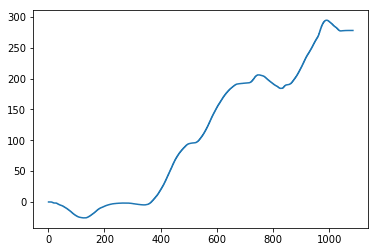

In [186]:
plt.plot(run.heading)

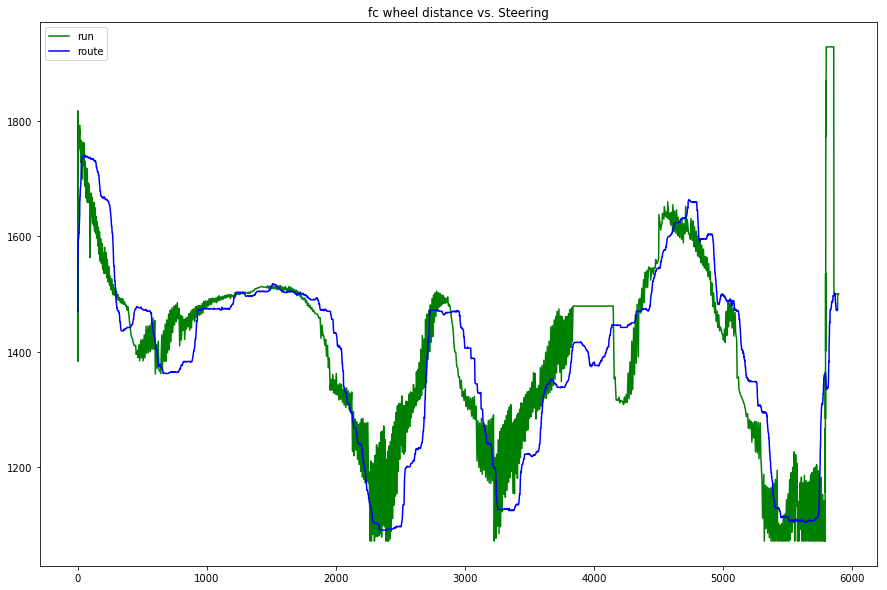

In [187]:
big_figure()
plt.title('fc wheel distance vs. Steering')
plt.plot(run.fc,run.str,color='g',label='run')
plt.plot(route.fc,route.str,color='b',label='route')
plt.legend();


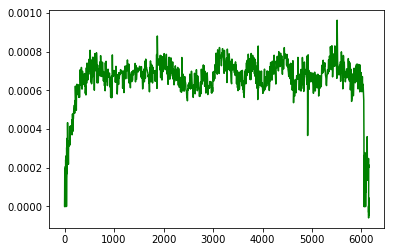

In [188]:
i = 1
plt.plot(run.fr[i:],(run.fr.values[i:]-run.fr.values[:-i])/(run.odo_fr_us.values[i:]-run.odo_fr_us.values[:-i]+1),color='g')
#plt.plot(route.fr[i:],route.fr.values[i:]-route.fr.values[:-i],color='b')

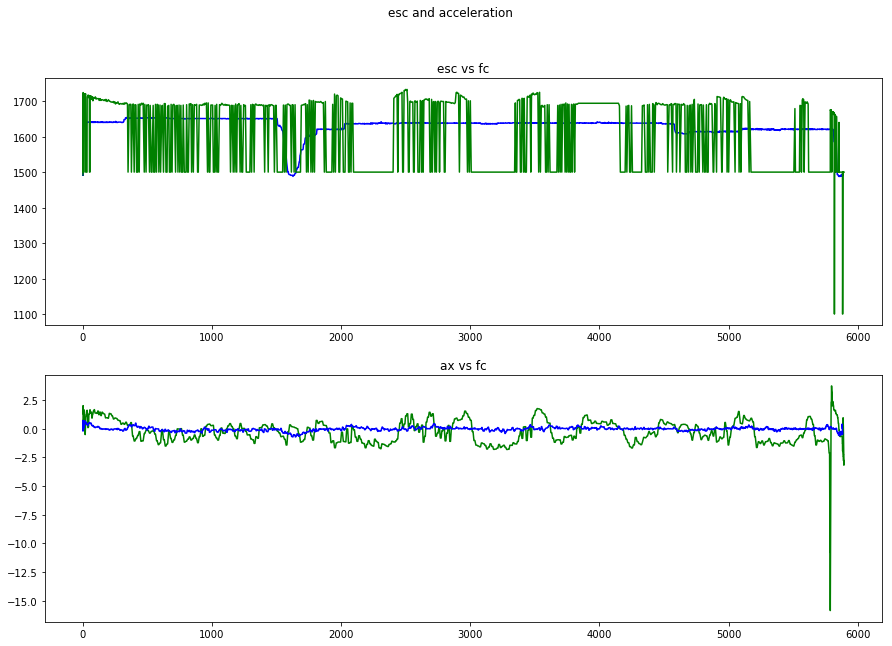

In [189]:
# research velocity
fig = big_figure()
fig.suptitle("esc and acceleration")
plt.subplot(2,1,1)
plt.plot(route.fc, route.esc, color='b')
plt.plot(run.fc, run.esc, color='g')
plt.title("esc vs fc")
plt.subplot(2,1,2)
plt.title('ax vs fc')
plt.plot(run.fc, run.ax,color='g');
plt.plot(route.fc, route.ax,color='b');

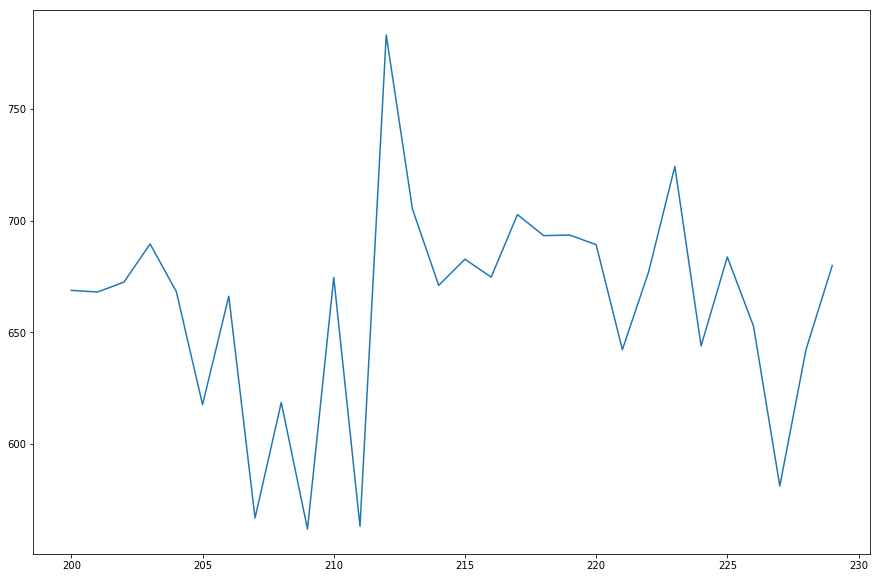

In [190]:
fr = run[['fr','odo_fr_us']]
fr.drop_duplicates(inplace=False)
d=fr.diff()
fig = big_figure()
plt.plot((d.fr/d.odo_fr_us*1E6)[200:230])


In [191]:
fig = plt.figure()

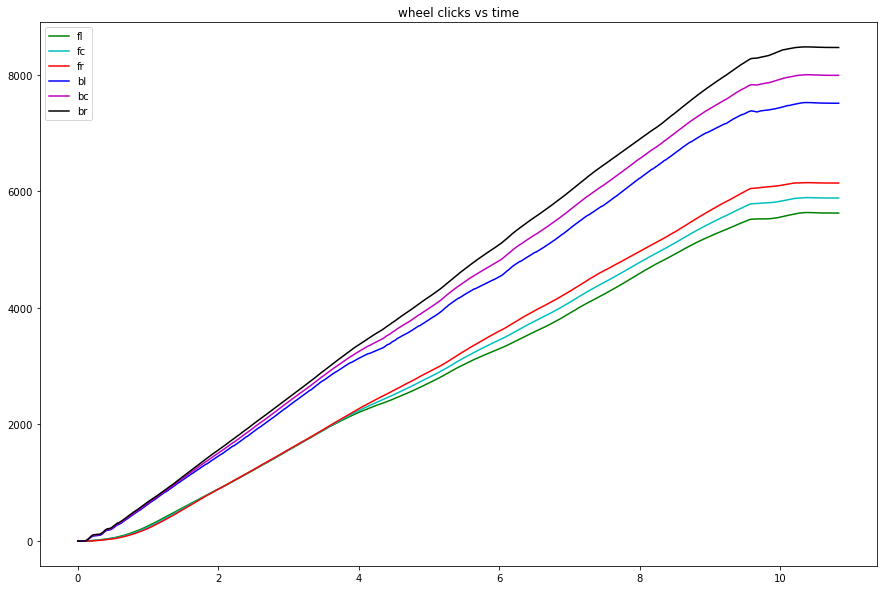

In [192]:
fig = plt.figure()
fig.set_size_inches(w=15,h=10)

ratio = 1 #.25
plt.title('wheel clicks vs time')
plt.plot(run.t,run.fl*ratio,color='g',label='fl')
plt.plot(run.t,run.fc*ratio,color='c', label='fc')
plt.plot(run.t,run.fr*ratio,color='r', label='fr')

plt.plot(run.t,run.bl,color='b', label='bl')
plt.plot(run.t,run.bc,color='m', label='bc')
plt.plot(run.t,run.br,color='k', label='br')
plt.legend();

In [193]:
v=np.zeros(len(run),np.float)

In [194]:
run.columns

Index(['timestamp', 'ms', 'us', 'str', 'esc', 'battery_voltage', 'odo_fl',
       'odo_fl_us', 'odo_fr', 'odo_fr_us', 'odo_bl', 'odo_bl_us', 'odo_br',
       'odo_br_us', 'odo_spur', 'odo_spur_us', 'yaw', 'pitch', 'roll', 'ax',
       'ay', 'az', 'imu_calib', 'fl', 'fr', 'bl', 'br'],
      dtype='object')

In [195]:
len(run.odo_fl[2:]),len(run.odo_fl_us[1:-1])
#plt.plot(np.diff(run.odo_fl)/np.diff(run.odo_fl_us))
d10 = (run.odo_fl[10:])-(run.odo_fl[0:])
#plt.plot(run.odo_fl,run.odo_fl[10:]-run.odo_fl[0:])
np.max(d10)
#plt.plot(run.odo_fl)

0.0

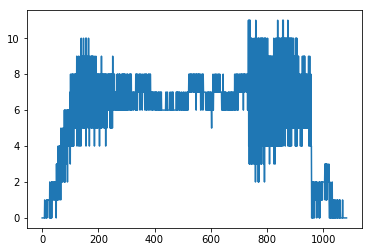

In [196]:
plt.plot(np.abs(np.diff(run.odo_fr,n=1)))

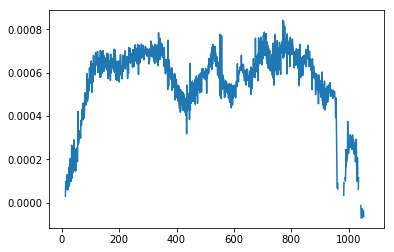

In [197]:
le = np.seterr(divide = 'ignore')
with np.errstate(invalid='ignore', divide='ignore'):
    plt.plot(np.divide(np.diff(run.odo_fl,n=1).astype(np.float),np.diff(run.odo_fl_us,n=1).astype(float)))
#np.seterr(le)

In [198]:
class KalmanFilter:
    def __init__(self, mean, variance):
        self.mean = float(mean)
        self.variance = float(variance)
    def measure(self,mean,variance):
        self.mean = (self.variance*float(mean)+self.mean*variance)/(self.variance+float(variance))
        self.variance = 1/((1/variance)+(1/self.variance))
    def update(self,distance,variance):
        self.mean += distance
        self.variance += variance                                                                    

In [199]:
def raw_v(odo,us,meters_per_odometer_tick):
    v = np.zeros_like(odo).astype(np.float)
    dx = np.diff(odo).astype(np.float)*meters_per_odometer_tick
    dt = np.diff(run.odo_fl_us).astype(np.float)/1E6
    with np.errstate(invalid='ignore', divide='ignore'):
        v[1:] = np.where(dt > 0, dx/dt,0)
    return v




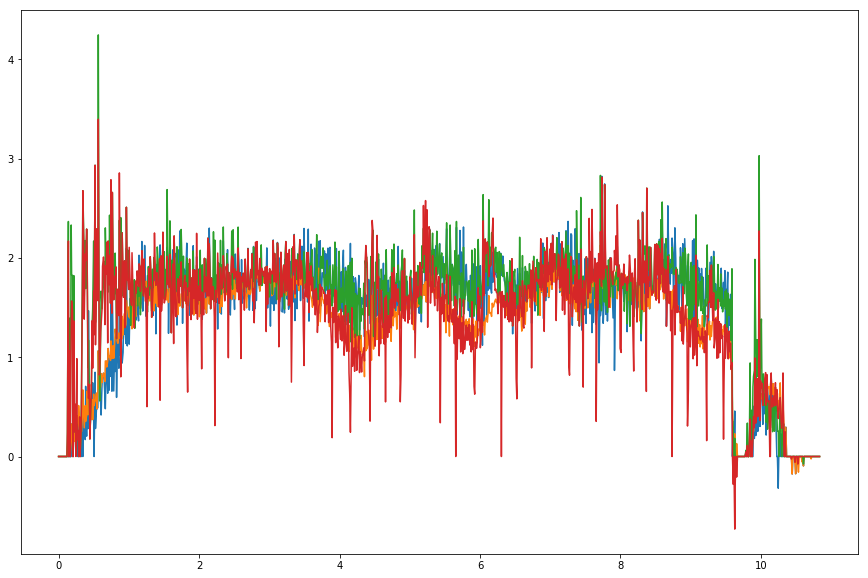

In [200]:
run.fr_v = raw_v(run.odo_fr,run.odo_fr_us, front_meters_per_odometer_tick)
run.fl_v = raw_v(run.odo_fl,run.odo_fl_us, front_meters_per_odometer_tick)
run.br_v = raw_v(run.odo_br,run.odo_br_us, rear_meters_per_odometer_tick)
run.bl_v = raw_v(run.odo_bl,run.odo_bl_us, rear_meters_per_odometer_tick)

big_figure()
plt.plot(run.t, run.fr_v)
plt.plot(run.t, run.fl_v)
plt.plot(run.t, run.br_v)
plt.plot(run.t, run.bl_v)


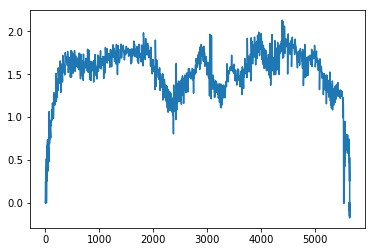

In [201]:
plt.plot(run.fl,run.fl_v)
    

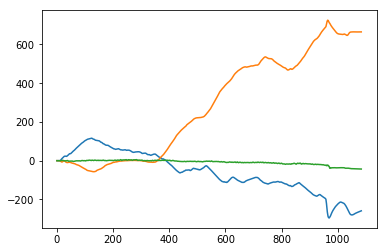

In [202]:
plt.plot(np.cumsum(run.ax))
plt.plot(np.cumsum(run.ay))
plt.plot(np.cumsum(run.az))

In [203]:
def kalman_v(ax,vraw):
    f = KalmanFilter(0,0)
    k_v = []
    for i,v in enumerate(vraw):
        f.update(0.01*ax[i],0.01**2)
        f.measure(v,.02)
        k_v.append(f.mean)
    return np.array(k_v)


In [204]:
run.fl_kv = kalman_v(run.ax,run.fl_v)
run.fr_kv = kalman_v(run.ax,run.fr_v)
run.bl_kv = kalman_v(run.ax,run.bl_v)
run.br_kv = kalman_v(run.ax,run.br_v)

In [205]:
run.fc_kv = (run.fl_kv+run.fr_kv)/2
run.fc_v =( run.fl_v+run.fr_v)/2

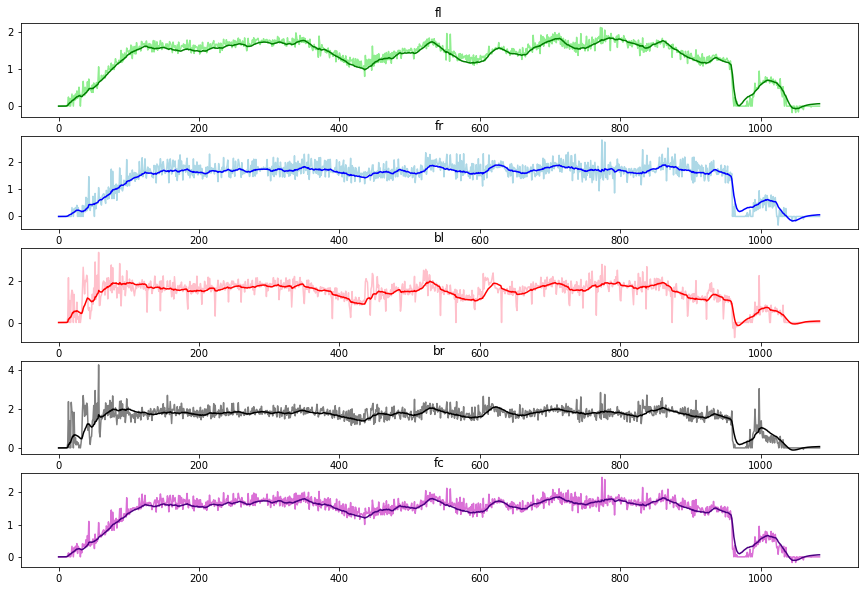

In [206]:
big_figure()
plt.subplot(5,1,1)
plt.title('fl')
plt.plot(run.fl_v,color='lightgreen')
plt.plot(run.fl_kv,color='green')

plt.subplot(5,1,2)
plt.title('fr')
plt.plot(run.fr_v,color='lightblue')
plt.plot(run.fr_kv,color='blue')

plt.subplot(5,1,3)
plt.title('bl')
plt.plot(run.bl_v,color='pink')
plt.plot(run.bl_kv,color='red')

plt.subplot(5,1,4)
plt.title('br')
plt.plot(run.br_v,color='gray')
plt.plot(run.br_kv,color='black')

plt.subplot(5,1,5)
plt.title('fc')
plt.plot(run.fc_v,color='orchid')
plt.plot(run.fc_kv,color='indigo')

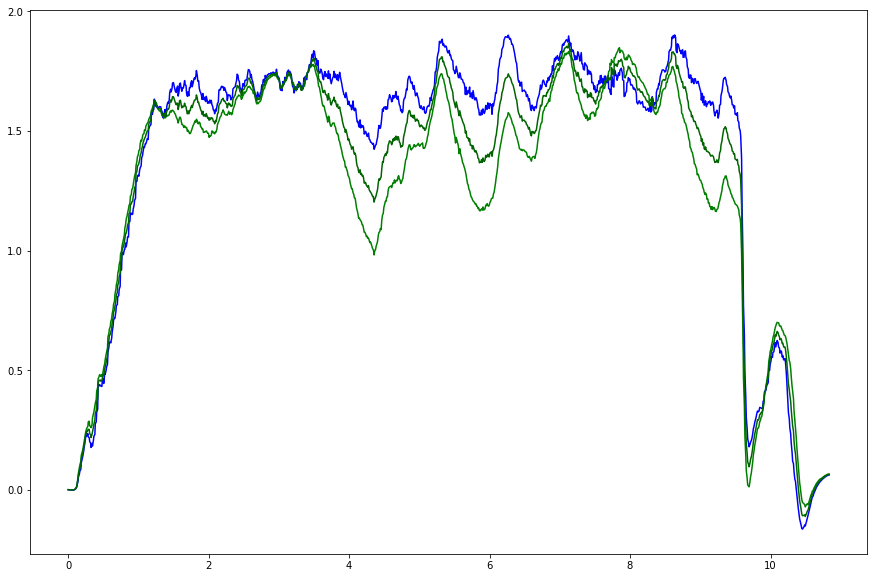

In [207]:
big_figure()
#plt.subplot(2,1,1)
plt.plot(run.t ,run.fl_kv, color='green')
plt.plot(run.t, run.fr_kv, color='blue')
plt.plot(run.t, run.fc_kv, color='darkgreen')
#plt.subplot(2,1,2)
#plt.plot(run.t, run.bl_kv, color='red')
#plt.plot(run.t, run.br_kv, color='black')


In [208]:
def diff_n(v,n=1):
    rv = np.zeros_like(v,dtype=np.float)
    rv[n:] = np.subtract(v[n:],v[0:-n])
    return rv

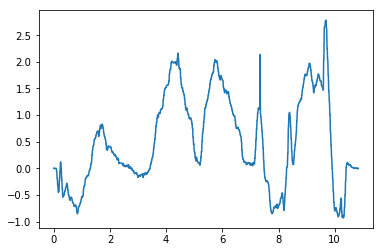

In [209]:
plt.plot(run.t,diff_n(run.heading,2))

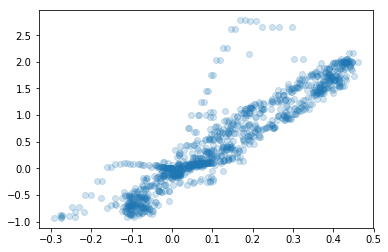

In [210]:
# How does wheel speed difference compare to turn rate?
run.dtheta=diff_n(run.heading,2)
plt.plot(run.fr_kv-run.fl_kv, run.dtheta,"o",alpha=0.2)

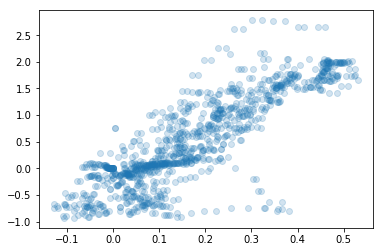

In [211]:
run.dtheta=diff_n(run.heading,2)
plt.plot(run.br_kv-run.bl_kv, run.dtheta,"o",alpha=0.2)

In [212]:
plt.plot(run.dtheta)
plt.title("dtheta

SyntaxError: EOL while scanning string literal (<ipython-input-212-59f54550c10e>, line 2)

In [ ]:
def bar_chart(d):
    '''
    plots a bar chart for dictionary d
    '''
    plt.bar(range(len(d)), d.values(), align='center')
    plt.xticks(range(len(d)), d.keys(),rotation=0,size=15)
    return plt

In [ ]:
d = {
    'fl_v':np.std(np.diff(run.fl_v)),
    'fr_v':np.std(np.diff(run.fr_v)),
    'fc_v':np.std(np.diff(run.fc_v)),
    'bl_v':np.std(np.diff(run.bl_v)),
    'br_v':np.std(np.diff(run.br_v)),
}
bar_chart(d);
plt.title('standard devaitions of successive measurements')

In [ ]:
d = 
bar_chart({"a":1,"b":3})

In [ ]:
print('standard deviation of subsequent k_v', np.std(np.diff(run.fl_kv)))

In [ ]:
print('standard deviation of subsequent fc_v',np.std(np.diff(run.fc_v)))

In [ ]:
print('standard deviation of subsequent fc_kv',np.std(np.diff(run.fc_kv)))